# About
### Task.
Achieve the best result in solving math tasks.

**Model:** [Mistral-small](https://docs.mistral.ai/api/)

**With hyperparameters:** 
* "temperature": 0.0, 
* "top_p": 1

**Evaluation metric:** num_of_correct / 100


### Final results.
**Accuracy:** 
* 77% (77/100 correct) - with only user prompt
* 55% (55/100 correct) - with system prompt

Working history: prompt_history.jsonl


As result of different methods and various prompts the best model can reach accuracy of **%, however there are some questions that are still defined incorrectly. 

Further steps to improve the results:
* errors can be the results of model weakneses, so it can be replaced with another one to solve it;
* design better prompts, it can help to increase the accuracy;
* try to add extra chains to get extra solution or another validation step;
* add tools (calculator) to perform mathematical operations in outputs. 



#### Extra notes.

During investigation I found that the answer for question 7 ```Joseph invested $1000 into a hedge fund...``` seems to be incorrect and should be 3844.51 instead of 3982.

# Import all required dependencies.

In [1]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage 
import os
import pandas as pd
import re
import statistics
import time
from dotenv import load_dotenv
import json
from langchain_mistralai.chat_models import ChatMistralAI
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

# Loading data.

### Input data structure.
Each row of the document contains:
* "question" - text of the math task
* "answer" - text of the expected result
* at the end of each answer there is the solution for the exact task (e.g. #### solution)

In [256]:
{
    'question': 'For every 12 ... ', 
    'answer': 'There are 144/12 = <<144/12=12>>12 ... \n#### 12'
}

{'question': 'For every 12 ... ',
 'answer': 'There are 144/12 = <<144/12=12>>12 ... \n#### 12'}

Load the api key to satisfy the access to Mistral models.

In [2]:
load_dotenv()
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

Read data from .jsonl file. Since it has incorrect punctuation, read it line by line.

Transform data into pandas dataframe. Separate the solution and convert it into integer for further comparison.

In [3]:
data = []

with open('math_problems.jsonl', 'r', encoding='utf-8') as f_in:
    for line in f_in:
        data.append(eval(line))

data_df = pd.DataFrame(data)
data_df = data_df.explode(['question', 'answer'])
data_df['target'] = data_df['answer'].apply(lambda x: int(x.split('####')[-1].strip()))

In [4]:
data_df.head()

,question,answer,target
0,"For every 12 cans you recycle, you receive $0....",There are 144/12 = <<144/12=12>>12 sets of 12 ...,12
1,Betty picked 16 strawberries. Matthew picked 2...,Matthew picked 16 + 20 = <<16+20=36>>36 strawb...,40
2,Jack has a stack of books that is 12 inches th...,There are 960 pages because 80 x 12 = <<80*12=...,160
3,James dumps his whole collection of 500 Legos ...,James starts with 500 Legos and uses half of t...,245
4,Ines had $20 in her purse. She bought 3 pounds...,Ines bought 3 pounds of peaches for 3 peaches ...,14


# Modeling.

In [5]:
# Define the parameters for mistral model
MODEL = "mistral-small-latest"
TEMPERATURE = 0
TOP_P = 1

## Mistral with only user prompts

Define function for prompting. This function receives only 'user' prompt and return the response.

In [11]:
# Function to interact with the Mistral API and get a response
def get_mistral_response(user_content):
    
    # Load api key
    client = MistralClient(api_key=MISTRAL_API_KEY)

    # Prepare a List of ChatMessage objects with the user's content
    messages = [
        ChatMessage(role="user", content=user_content),
        ]
    
    # Get the response from the Mistral API 
    chat_response = client.chat(
        model=MODEL, 
        temperature=TEMPERATURE,
        top_p=TOP_P,
        messages=messages,
        )
    
    try:
        # Extract the content from the response
        response_content = " ".join([choice.message.content for choice in chat_response.choices]) if chat_response.choices else ""
    except AttributeError as e:
        print(f"An error occurred while processing the response: {e}")
        response_content = ""
    # Return the response content
    return response_content

Allow to get the result for single or list of prompts with expected results:

In [179]:
N_RECORD = [58, ]

for record in N_RECORD:
    print(f"******************* Record {record} ************************")

    # Prompt
    user_content = data_df.iloc[record,0]
    
    # print prompt text
    print(user_content)

    # Result
    print("Full response:")
    response = get_mistral_response(user_content)
    print (f"{response}")
    print('*'*100)
    print(f"Expected output: {data_df.iloc[record,2]}")

******************* Record 58 ************************
A wheel on a certain machine makes 6 turns every 30 seconds. How many turns does it make in two hours?
Full response:


First, let's find out how many turns the wheel makes in one minute since there are 60 seconds in a minute:

Turns in 1 minute = Turns per 30 seconds * (Seconds per minute / Seconds per turn)
                 = 6 * (60 / 30)
                 = 6 * 2
                 = 12 turns

Now, let's calculate how many turns the wheel makes in two hours. We know that there are 60 minutes in an hour, so:

Turns in 2 hours = Turns per minute * Minutes per hour * Number of hours
                = 12 * 60 * 2
                = 1440 * 2
                = 2880 turns

So, the wheel makes 2880 turns in two hours.
****************************************************************************************************
Expected output: 1440


As result of prompting single questions such points can be defined:
* the response doesn't have the only result we are looking for and it requires some processing operations;
* also it seems the result is usually located at the end of response, so it can be extracted with Regular Expression methods;
* obviously model can solve task incorrectly, but in different prompts results can be different;
* to extract the only solution from different prompt results it can be suitable to use Mode to get the most frequent one. 

In [7]:
re_exp = r'\b\d+(?:\.\d+)?(?:\,\d+)?\b'

#results_0_0 = dict() # one base prompt without extra ones
results_0_3 = dict() # 3 base prompt 
#results_0_5 = dict() # 5 base prompt 

results_1 = dict() # with 1 extra
results_3 = dict() # with 3 extra
results_5 = dict() # with 5 extra

# Record the results into dataframe
for i, question in enumerate(data_df['question']):
    print(f"Working: {i} prompt ...")
    response_0 = get_mistral_response(question)
    response_1 = get_mistral_response(question)
    time.sleep(2)  
    response_2 = get_mistral_response(question)
    #response_3 = get_mistral_response(question)
    #response_4 = get_mistral_response(question)
    #time.sleep(2)  
    
    # base requests    
    output_0_0 = re.findall(re_exp, response_0)[-1]
    output_0_1 = re.findall(re_exp, response_1)[-1]
    output_0_2 = re.findall(re_exp, response_2)[-1]
    #output_0_3 = re.findall(re_exp, response_3)[-1]
    #output_0_4 = re.findall(re_exp, response_4)[-1]
 
    #results_0_0[i] = statistics.mode(results_0_0.get(i, []) + [output_0_0,])
    results_0_3[i] = statistics.mode(results_0_3.get(i, []) + [output_0_0,] + [output_0_1,] + [output_0_2,])
    #results_0_5[i] = statistics.mode(results_0_5.get(i, []) + [output_0_0,] + [output_0_1,] + [output_0_2,] + [output_0_3,] + [output_0_4,])

    if results_0_3[i] == output_0_0:
        response = response_0
    elif results_0_3[i] == output_0_1:
        response = response_1
    else:
        response = response_2
    

    new_prompt_1 = 'What is the final number of the solution: ' + response
    new_prompt_2 = 'Provide only the resulting number of the solution: ' + response
    new_prompt_3 = 'Give only the result number of the solution: ' + response
    new_prompt_4 = 'What is the final numerical value of the solution: ' + response
    new_prompt_5 = 'Provide the final answer number of the solution: ' + response


    # extra prompts
    output_1 = re.findall(re_exp, get_mistral_response(new_prompt_1))[-1]  
    output_2 = re.findall(re_exp, get_mistral_response(new_prompt_2))[-1]
    time.sleep(2)  
    output_3 = re.findall(re_exp, get_mistral_response(new_prompt_3))[-1]  
    output_4 = re.findall(re_exp, get_mistral_response(new_prompt_4))[-1]  
    output_5 = re.findall(re_exp, get_mistral_response(new_prompt_5))[-1]  
    time.sleep(2)  


    results_1[i] = statistics.mode(results_1.get(i, []) + [results_0_3[i],] + [output_1,])
    results_3[i] = statistics.mode(results_3.get(i, []) + [results_0_3[i],] + [output_1,] + [output_2,] + [output_3,])
    results_5[i] = statistics.mode(results_5.get(i, []) + [results_0_3[i],] + [output_1,] + [output_2,] + [output_3,] + [output_4,] + [output_5,])

    #if i > 3:
    #    break
print("Done!")

Working: 0 prompt ...
Working: 1 prompt ...
Working: 2 prompt ...
Working: 3 prompt ...
Working: 4 prompt ...
Working: 5 prompt ...
Working: 6 prompt ...
Working: 7 prompt ...
Working: 8 prompt ...
Working: 9 prompt ...
Working: 10 prompt ...
Working: 11 prompt ...
Working: 12 prompt ...
Working: 13 prompt ...
Working: 14 prompt ...
Working: 15 prompt ...
Working: 16 prompt ...
Working: 17 prompt ...
Working: 18 prompt ...
Working: 19 prompt ...
Working: 20 prompt ...
Working: 21 prompt ...
Working: 22 prompt ...
Working: 23 prompt ...
Working: 24 prompt ...
Working: 25 prompt ...
Working: 26 prompt ...
Working: 27 prompt ...
Working: 28 prompt ...
Working: 29 prompt ...
Working: 30 prompt ...
Working: 31 prompt ...
Working: 32 prompt ...
Working: 33 prompt ...
Working: 34 prompt ...
Working: 35 prompt ...
Working: 36 prompt ...
Working: 37 prompt ...
Working: 38 prompt ...
Working: 39 prompt ...
Working: 40 prompt ...
Working: 41 prompt ...
Working: 42 prompt ...
Working: 43 prompt ..

In [8]:
#data_df['predict_1base'] = list(results_0_0.values())
data_df['predict_3base'] = list(results_0_3.values())
#data_df['predict_5base'] = list(results_0_5.values())

data_df['predict_1extra'] = list(results_1.values())
data_df['predict_3extra'] = list(results_3.values())
data_df['predict_5extra'] = list(results_5.values())

In [ ]:
data_df['target'] = data_df['target'].apply(lambda x: int(float(x)))
#data_df['predict_1base'] = data_df['predict_1base'].apply(lambda x: int(float(x)))
data_df['predict_3base'] = data_df['predict_3base'].apply(lambda x: int(float(x)))
#data_df['predict_5base'] = data_df['predict_5base'].apply(lambda x: int(float(x)))
data_df['predict_1extra'] = data_df['predict_1extra'].apply(lambda x: int(float(x)))
data_df['predict_3extra'] = data_df['predict_3extra'].apply(lambda x: int(float(x)))
data_df['predict_5extra'] = data_df['predict_5extra'].apply(lambda x: int(float(x)))

In [165]:
data_df[(data_df['target'] != data_df['predict_3base']) | (data_df['target'] != data_df['predict_1extra']) | (data_df['target'] != data_df['predict_3extra']) | (data_df['target'] != data_df['predict_5extra'])]

,question,answer,target,predict_1base,predict_3base,predict_5base
6,Joseph invested $1000 into a hedge fund. The f...,"For the first year, Joseph will have invested ...",3982,3639,3639,3639
9,The Rotary Club is holding its annual fundrais...,They'll need to make an estimated 0.5 * 53 = <...,584,596,596,596
10,John buys cans of soup for buy 1 get one free....,He pays for 30/2=<<30/2=15>>15 cans\nSo he spe...,9,30,30,30
15,Fern buys one pair of high heels for $60 and f...,First find the cost of one pair of ballet slip...,260,260,260,246
17,Every hour past noon shadows from a building s...,"If the shadows lengthen by 5 feet per hour, th...",360,6,6,6
18,A fox can run at the maximum speed of 50 kilom...,"1 hour is 60 minutes, so 120 minutes is 120 / ...",100,2,2,2
23,Each dandelion produces 300 seeds. 1/3rd of th...,First find the number of seeds that land in wa...,75,100,100,100
24,"By the time Anne is two times as old as Emile,...",If Maude's age is 8 by the time Anne's age is ...,96,8,8,8
26,TreShawn's mom needs to order pizza for her so...,Half a pizza is the same as 3/6 of a pizza\n1/...,1,3,3,3
29,Barry stands on his head for 10 minutes at a t...,Each turn Barry takes standing on his head las...,8,2,2,2


In [166]:
print("Accuracy: ")
print("1 base prompt: ", data_df[(data_df['target'] == data_df['predict_1base'])].shape[0]/data_df.shape[0] * 100, '%')
print("3 base prompt: ", data_df[(data_df['target'] == data_df['predict_3base'])].shape[0]/data_df.shape[0] * 100, '%')
print("5 base prompt: ", data_df[(data_df['target'] == data_df['predict_5base'])].shape[0]/data_df.shape[0] * 100, '%')

Accuracy: 
1 base prompt:  71.0 %
3 base prompt:  72.0 %
5 base prompt:  71.0 %


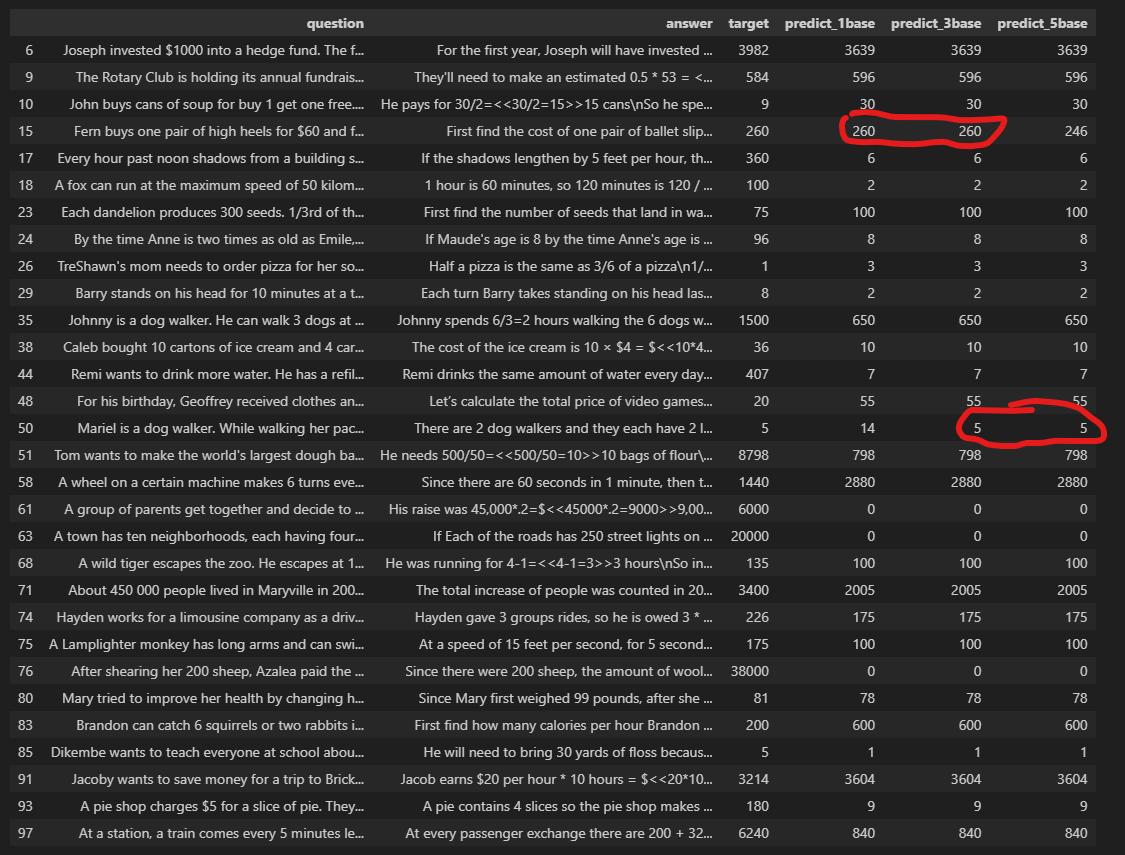

### Conclusion for only user prompts:

There are 29 errors which mostly the same for different methods. Some of them model can't solve correctly, but some are not correct, because answer is not the last number. 

Some errors are fixed with adding ',' to Regular Expression to include numbers e.g. 2,456.

In case of only user prompts it shows following accuracy results:
* 1 base prompt:  76.0 %
* 3 base prompt:  77.0 %
* 5 base prompt:  76.0 %

## Mistral with system prompt

In [44]:
# define list of questions that were incorrectly and correctly solved
incorrect_answ = [6,9,15,23,26,29,35,38,44,48,50,58,68,74,75,80,83,91,97]

In [223]:
# define alternative list with incorrect and correct answers for the last method
answers_to_compare = [3,6,9,12,15,18,23]

Create function to track all responses and record them into file:

In [6]:
def record_results(math_task, student_response, teacher_response):
    # Record prompts and results into file
    data_to_save = {
        "task": math_task, 
        "student_answer": student_response, 
        "teacher_answer": teacher_response
        }
    with open("prompt_history.jsonl", 'a') as f_out:
        json.dump(data_to_save, f_out)
        f_out.write('\n')

### One task at once to solve

Next I am using one prompt to make a solution and next prompt to check this solution.

So it is described as a student and a teacher. They are working with only one task per time.

In [224]:
# system content for 1st and 2nd prompt 
system_performer = "You are a student who solves mathematical tasks. It is known that all solutions are integers. Always re-check your solution 3 times."
system_checker = "You are a professor who checking students mathematical tasks. Always re-check student's solution 3 times. Add correct solution value at the end of the output after '###' (any extra words, units or task numbers are prohibited). It is known that all solutions are integers."

In [7]:
# Function to interact with the Mistral API 
def get_mistral_response_with_system(user_content, system_content):
    
    # Load api key
    client = MistralClient(api_key=MISTRAL_API_KEY)

    # Prepare a List of ChatMessage objects with the user's content
    messages = [
        ChatMessage(role="system", content=system_content),
        ChatMessage(role="user", content=user_content),
        ]
    
    # Get the response from the Mistral API without streaming
    chat_response = client.chat(
        model=MODEL, 
        temperature=TEMPERATURE,
        top_p=TOP_P,
        messages=messages
        )
    
    try:
        # Extract the content from the response
        response_content = " ".join([choice.message.content for choice in chat_response.choices]) if chat_response.choices else ""
    except AttributeError as e:
        print(f"An error occurred while processing the response: {e}")
        response_content = ""
    # Return the response content
    return response_content


In [226]:
result_dict_single = dict()  # Single prompt dictionary: key - question, item - answers

In [227]:
N_RECORD = answers_to_compare #incorrect_answ[0:6]

for record in N_RECORD:
    print(f"******************* Record {record} ************************")

    # Question Prompt
    math_task = data_df.iloc[record,0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_system(math_task, system_performer)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"Task: {math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_system(teacher_prompt, system_checker)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[record,2]}")

    # Record prompts and results into file
    record_results(math_task, student_response, teacher_response)

    # results to dict
    result_dict_single[math_task] = result_dict_single.get(math_task, []) + [teacher_response.split('###')[-1].strip(), ]

******************* Record 3 ************************
Question: 
 James dumps his whole collection of 500 Legos on the floor and starts building a castle out of them.  He uses half the pieces before finishing and is told to put the rest away.  He puts all of the leftover pieces back in the box they came from, except for 5 missing pieces that he can't find.  How many Legos are in the box at the end?
Student answer:
James used half of his 500 Legos, which means he used 500 / 2 = 250 Legos.
He lost 5 Legos, so he has 500 - 250 - 5 = 245 Legos left.
Since he put all the leftover pieces back in the box, there are 245 Legos in the box at the end.

Let's re-check the solution:
1. James used 250 Legos and lost 5, so he has 500 - 250 - 5 = 245 Legos left.
2. James used half of his Legos and lost 5, so he has 500 / 2 - 5 = 245 Legos left.
3. James used 250 Legos and put the rest in the box, so he has 500 - 250 = 250 Legos in the box, but he lost 5, so he has 250 - 5 = 245 Legos in the box.

The 

### Pass 3 tasks for each student and teacher.

Next idea is using one prompt, but with 3 tasks at once for a student and a teacher.

In [228]:
system_performer = "You are a student who solves mathematical tasks. You always get three tasks to solve. It is known that all solutions must be integers. Always re-check each your solution 3 times."
system_checker = "You are a professor who checking students mathematical tasks. You always get three tasks and tree solutions to check. Always re-check student's solutions 3 times.  It is known that all solutions must be integers. You must write all correct integers at the end of the output with '###' before each solution (any extra words, units or task numbers are prohibited)."

In [229]:
result_dict_multi = dict()  # Multi prompt dictionary: key - question, item - answers

In [230]:
N_RECORD = answers_to_compare #incorrect_answ[0:6]

for record in range(len(N_RECORD)):

    # Check is the identifiers of question inside the range
    record_1 = record
    if record+1 >= len(N_RECORD):
        record_2 = record + 1 - len(N_RECORD)
        record_3 = record + 2 - len(N_RECORD)
    elif record+2 >= len(N_RECORD):
        record_2 = record + 1
        record_3 = record + 2 - len(N_RECORD)
    else:
        record_2 = record + 1
        record_3 = record + 2

    print(f"******************* Records {N_RECORD[record_1]}, {N_RECORD[record_2]}, {N_RECORD[record_3]} ************************")

    math_task = "task 1: " + data_df.iloc[N_RECORD[record_1],0] + "\ntask 2: " + data_df.iloc[N_RECORD[record_2],0] + "\ntask 3: " + data_df.iloc[N_RECORD[record_3],0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_system(math_task, system_performer)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"Task: {math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_system(teacher_prompt, system_checker)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[N_RECORD[record_1],2]}#{data_df.iloc[N_RECORD[record_2],2]}#{data_df.iloc[N_RECORD[record_3],2]}")

    # Record prompts and results into file
    record_results(math_task, student_response, teacher_response)

    # results to dict
    result_dict_multi[data_df.iloc[N_RECORD[record_1],0]] = result_dict_multi.get(data_df.iloc[N_RECORD[record_1],0], []) + [teacher_response.split('###')[-3].strip(),]
    result_dict_multi[data_df.iloc[N_RECORD[record_2],0]] = result_dict_multi.get(data_df.iloc[N_RECORD[record_2],0], []) + [teacher_response.split('###')[-2].strip(),]
    result_dict_multi[data_df.iloc[N_RECORD[record_3],0]] = result_dict_multi.get(data_df.iloc[N_RECORD[record_3],0], []) + [teacher_response.split('###')[-1].strip(),]

******************* Records 3, 6, 9 ************************
Question: 
 task 1: James dumps his whole collection of 500 Legos on the floor and starts building a castle out of them.  He uses half the pieces before finishing and is told to put the rest away.  He puts all of the leftover pieces back in the box they came from, except for 5 missing pieces that he can't find.  How many Legos are in the box at the end?
task 2: Joseph invested $1000 into a hedge fund. The fund promised a yearly interest rate of 10%. If he deposited an additional $100 every month into the account to add to his initial investment of $1000, how much money will he have in the fund after two years?
task 3: The Rotary Club is holding its annual fundraising Omelet Breakfast, with tickets sold in advance. The tickets come in different price levels, for young children, older children, adults, and seniors. This year they sold 53 small children tickets, 35 older children tickets, 75 adult tickets, and 37 senior tickets.

### Pass 5 tasks for each student and teacher.

Next step will pass 5 task to solve each time.

In [231]:
system_performer = "You are a student who solves mathematical tasks. You always get five tasks to solve. It is known that all solutions must be integers. Always re-check each your solution 3 times."
system_checker = "You are a professor who checking students mathematical tasks. You always get five tasks and five solutions to check. Always re-check student's solutions 3 times.  It is known that all solutions must be integers. You must write all correct integers at the end of the output with '###' before each solution (any extra words, units or task numbers are prohibited)."

In [232]:
result_dict_multi_5 = dict()  # Multi prompt dictionary: key - question, item - answers

In [233]:
N_RECORD = answers_to_compare #incorrect_answ[0:6]

for record in range(len(N_RECORD)):

    # Check is the identifiers of question inside the range
    record_1 = record
    if record+1 >= len(N_RECORD):
        record_2 = record + 1 - len(N_RECORD)
        record_3 = record + 2 - len(N_RECORD)
        record_4 = record + 3 - len(N_RECORD)
        record_5 = record + 4 - len(N_RECORD)
    elif record+2 >= len(N_RECORD):
        record_2 = record + 1
        record_3 = record + 2 - len(N_RECORD)
        record_4 = record + 3 - len(N_RECORD)
        record_5 = record + 4 - len(N_RECORD)
    elif record+3 >= len(N_RECORD):
        record_2 = record + 1
        record_3 = record + 2
        record_4 = record + 3 - len(N_RECORD)
        record_5 = record + 4 - len(N_RECORD)
    elif record+4 >= len(N_RECORD):
        record_2 = record + 1
        record_3 = record + 2
        record_4 = record + 3
        record_5 = record + 4 - len(N_RECORD)
    else:
        record_2 = record + 1
        record_3 = record + 2
        record_4 = record + 3
        record_5 = record + 4

    print(f"******************* Records {N_RECORD[record_1]}, {N_RECORD[record_2]}, {N_RECORD[record_3]}, {N_RECORD[record_4]}, {N_RECORD[record_5]} ************************")

    math_task = "task 1: " + data_df.iloc[N_RECORD[record_1],0] + "\ntask 2: " + data_df.iloc[N_RECORD[record_2],0] + "\ntask 3: " + data_df.iloc[N_RECORD[record_3],0] + "\ntask 4: " + data_df.iloc[N_RECORD[record_4],0] + "\ntask 5: " + data_df.iloc[N_RECORD[record_5],0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_system(math_task, system_performer)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"Task: {math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_system(teacher_prompt, system_checker)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[N_RECORD[record_1],2]}#{data_df.iloc[N_RECORD[record_2],2]}#{data_df.iloc[N_RECORD[record_3],2]}#{data_df.iloc[N_RECORD[record_4],2]}#{data_df.iloc[N_RECORD[record_5],2]}")

    # Record prompts and results into file
    record_results(math_task, student_response, teacher_response)

    # results to dict
    result_dict_multi_5[data_df.iloc[N_RECORD[record_1],0]] = result_dict_multi_5.get(data_df.iloc[N_RECORD[record_1],0], []) + [teacher_response.split('###')[-5].strip(),]
    result_dict_multi_5[data_df.iloc[N_RECORD[record_2],0]] = result_dict_multi_5.get(data_df.iloc[N_RECORD[record_2],0], []) + [teacher_response.split('###')[-4].strip(),]
    result_dict_multi_5[data_df.iloc[N_RECORD[record_3],0]] = result_dict_multi_5.get(data_df.iloc[N_RECORD[record_3],0], []) + [teacher_response.split('###')[-3].strip(),]
    result_dict_multi_5[data_df.iloc[N_RECORD[record_4],0]] = result_dict_multi_5.get(data_df.iloc[N_RECORD[record_4],0], []) + [teacher_response.split('###')[-2].strip(),]
    result_dict_multi_5[data_df.iloc[N_RECORD[record_5],0]] = result_dict_multi_5.get(data_df.iloc[N_RECORD[record_5],0], []) + [teacher_response.split('###')[-1].strip(),]

******************* Records 3, 6, 9, 12, 15 ************************
Question: 
 task 1: James dumps his whole collection of 500 Legos on the floor and starts building a castle out of them.  He uses half the pieces before finishing and is told to put the rest away.  He puts all of the leftover pieces back in the box they came from, except for 5 missing pieces that he can't find.  How many Legos are in the box at the end?
task 2: Joseph invested $1000 into a hedge fund. The fund promised a yearly interest rate of 10%. If he deposited an additional $100 every month into the account to add to his initial investment of $1000, how much money will he have in the fund after two years?
task 3: The Rotary Club is holding its annual fundraising Omelet Breakfast, with tickets sold in advance. The tickets come in different price levels, for young children, older children, adults, and seniors. This year they sold 53 small children tickets, 35 older children tickets, 75 adult tickets, and 37 senior 

task 1: James uses half of his 500 Legos to build the castle, which is 500 / 2 = 250 Legos. He loses 5 Legos, so there are 250 - 5 = 245 Legos left. He puts all the remaining Legos back in the box, so there are 245 Legos in the box at the end.

task 2: Joseph earns a 10% yearly interest on his investment. Over two years, he will earn 10% * 2 = 20% of his initial investment. He also deposits an additional $100 every month for 24 months (2 years). So, he deposits a total of $100 * 24 = $2400. His total investment is $1000 + $2400 = $3400. With a 20% interest, he will earn $3400 * 20% = $680. So, he will have $1000 + $680 + $2400 = $4080 in the fund after two years.

task 3: The Rotary Club needs to make 53 * 1/2 + 35 * 1 + 75 * 2 + 37 * 1.5 + 25 = 26.5 + 35 + 150 + 55.5 + 25 = 292 omelets. Since they use 2 eggs for each omelet, they will need 292 * 2 = 584 eggs.

task 4: Grant has 4 * 90 = 360 vacations. Together, they have 360 vacations + 90 classes = 450 vacations and classes.

task 5:

In [122]:
print(incorrect_answ[0:6])
print(result_dict_single.values())
print(result_dict_multi.values())
print(result_dict_multi_5.values())

[6, 9, 15, 23, 26, 29]
dict_values([['$3160.'], ['586'], ['100'], ['100'], ['6'], ['8']])
dict_values([['3830', '3730'], ['584', '293'], ['260', '260', '260'], ['12', '1', '1'], ['6', '8', '6'], ['1', '12']])
dict_values([['3600', '3610', '4080', '3730', '1744'], ['584', '293', '584', '584', '584'], ['260', '260', '260', '260', '300'], ['25', '1', 'Cannot be determined', '', '25 (Note: This answer is in terms of seeds, not dandelions)'], ['36', '1', '6', '0', '6'], ['12', '12', '8', '8', '8']])


### Results (on first 6 strugling questions 6, 9, 15, 23, 26, 29):

*Mode applied for multiple solutions*

(Ask model to check 3 times each solution)
* Single task -     2/6 (correct questions: 15, 29)                           
* 3 task at once -  2/6 (correct questions: 9(2/3), 15, 23(1/3))              
* 5 tasks at once - 4/6 (correct questions: 9(4/5), 15(4/5), 26(2/5), 29(4/5)) 

(Ask student to recheck 3 times and teacher to check 10 times each solution)
* Single task -    2/6 (correct questions: 15, 29)                       
* 3 task at once - 2/6 (correct questions: 9(2/3), 15, 23(1/3)) 

(Ask student to recheck 10 times and teacher to check 3 times each solution)
* Single task -    1/6 (correct questions: 29)    
* 3 task at once - 2/6 (correct questions: 9, 15) 

# LangChain

The other way of prompting with LangChain which allow to work with LLM more widely and parse the results.

System content - Option 1.

In [234]:
system_math_template_1 = """You are an outstanding expert in solving math exercises. \
    """
system_math_template_2 = """You are an excellent expert in algebraic exercises. \
    Check the student's solution and write the correct answer.
    """

System content - Option 2.

In [257]:
system_math_template_1 = """Welcome, math virtuoso! \
Your talent in tackling math challenges is unparalleled, attributed to your habit of triple-checking your solutions. \
"""
system_math_template_2 = """You are a math prodigy with an expertise in problem-solving. \
Your proficiency lies in triple-checking solutions, ensuring accuracy. \
Evaluate the student's solution and provide the correct answer.
"""

System content - Option 3.

In [216]:
system_math_template_1 = "You are a student who solves mathematical tasks. It is known that all solutions are integers. Always re-check your solution 3 times."
system_math_template_2 = "You are a professor who checking students mathematical tasks. Always re-check student's solution 3 times. It is known that all solutions are integers."

Define function to prompt Mistral with LangChain:

In [8]:
def get_mistral_response_with_langchain(math_task, system_message):
    # define a model
    chat = ChatMistralAI(
        mistral_api_key=MISTRAL_API_KEY,
        model=MODEL, 
        temperature=TEMPERATURE,
        top_p=TOP_P,
        )
    
    # Config schemas for required output data
    explanation_schema = ResponseSchema(name="explanation",
                                        description="A concise description of the solution.")

    solution_schema = ResponseSchema(name="solution",
                                     description="The final solution presented as an integer with no additional units or words.")

    response_schemas = [explanation_schema, 
                        solution_schema]
                        
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    format_instructions = output_parser.get_format_instructions()

    # define a template for prompts
    template = """\
    {system_message}

    Time to showcase your mathematical prowess. 
    Solve the following task with the best solution:
    task: {text}

    Extract the following information:

    explanation: A concise description of the solutions.

    solution: The solution with no additional units or words.

    {format_instructions}
    """

    # prompt the model
    prompt = ChatPromptTemplate.from_template(template=template)
    messages = prompt.format_messages(system_message=system_message,
                                      text=math_task, 
                                      format_instructions=format_instructions)
    # get the response
    response = chat.invoke(messages)

    # parse the output and return the solution
    try:
        output_dict = output_parser.parse(response.content)
        return output_dict.get('solution')
    except:
        return response


In [259]:
result_dict_langch_single = dict()

In [254]:
N_RECORD = answers_to_compare #incorrect_answ[0:6]

for record in N_RECORD:
    print(f"******************* Record {record} ************************")

    # Question Prompt
    math_task = data_df.iloc[record,0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_langchain(math_task, system_math_template_1)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"{math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_langchain(teacher_prompt, system_math_template_2)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[record,2]}")

    # Record prompts and results into file
    record_results(math_task, student_response, teacher_response)

    # results to dict
    result_dict_langch_single[math_task] = result_dict_langch_single.get(math_task, []) + [teacher_response, ]

******************* Record 3 ************************
Question: 
 James dumps his whole collection of 500 Legos on the floor and starts building a castle out of them.  He uses half the pieces before finishing and is told to put the rest away.  He puts all of the leftover pieces back in the box they came from, except for 5 missing pieces that he can't find.  How many Legos are in the box at the end?
Student answer:
[245]
****************************************************************************************************
Teacher prompt: 
 James dumps his whole collection of 500 Legos on the floor and starts building a castle out of them.  He uses half the pieces before finishing and is told to put the rest away.  He puts all of the leftover pieces back in the box they came from, except for 5 missing pieces that he can't find.  How many Legos are in the box at the end? 
Student answer: [245]
Teacher answer: 
[245, 245, 245]
*****************************************************************

In [255]:
print(answers_to_compare)
print(result_dict_single.values())
print(result_dict_multi.values())
print(result_dict_multi_5.values())
print(result_dict_langch_single.values())

[3, 6, 9, 12, 15, 18, 23]
dict_values([['245'], ['3820'], ['606'], ['450'], ['260'], ['100'], ['100']])
dict_values([['245', '245', '245'], ['3600', '3600', '3820'], ['584', '584', '293'], ['450', '360', '450 (total events for Grant and Kelvin)'], ['260', '260 (total amount Fern pays)', '100\nTask 2:'], ['100 (distance the fox runs)', '100\nTask 3:', '100'], ['0\n\nExplanation:\nTask 1: Fern pays $60 for one pair of high heels and $40 for five pairs of ballet slippers, making a total of $100.\nTask 2: The fox runs at a speed of 50 kilometers per hour and runs for 2 hours, covering a distance of 100 kilometers.\nTask 3: Each dandelion produces 300 seeds, but 100 seeds land in water and die, 50 seeds are eaten by insects, and 125 seeds sprout and are immediately eaten, leaving no seeds to flower.', '0', '25']])
dict_values([['245', '245', '745', '245', '240'], ['4080', '', '3730', '2450', '3860'], ['584', '3600', '293', '584', '560'], ['450', '584', '450', '360', '450 (360 vacations + 90

[3, 6, 9, 12, 15, 18, 23]

['245'], 
    ['3820'], 
        ['606'], 
            ['450'], 
                ['260'], 
                    ['100'], 
                        ['100']])

['245', '245', '245'], 
    ['3600', '3600', '3820'], 
        ['584', '584', '293'], 
            ['450', '360', '450 (total events for Grant and Kelvin)'], 
                ['260', '260 (total amount Fern pays)', '100\nTask 2:'], 
                    ['100 (distance the fox runs)', '100\nTask 3:', '100'], 
                        ['0\n\nExplanation:\nTask 1: Fern pays $60 for one pair of high heels and $40 for five pairs of ballet slippers, making a total of $100.\nTask 2: The fox runs at a speed of 50 kilometers per hour and runs for 2 hours, covering a distance of 100 kilometers.\nTask 3: Each dandelion produces 300 seeds, but 100 seeds land in water and die, 50 seeds are eaten by insects, and 125 seeds sprout and are immediately eaten, leaving no seeds to flower.', '0', '25']])

['245', '245', '745', '245', '240'], 
    ['4080', '', '3730', '2450', '3860'], 
        ['584', '3600', '293', '584', '560'], 
            ['450', '584', '450', '360', '450 (360 vacations + 90 classes)'], 
                ['260', '450', '100', '450', '260'], 
                    ['260 (The distance for task 5 cannot be determined without knowing the actual speed at which the fox is running.)', '100', '100', '100', '100'], 
                        ['1', '100', '75', '0', '125']])

[[245, 245, 245]], 
    [14693.01, 14693.01, 14693.01]],    
        [1150, 1150, 1150]], 
            [450]], 
                [260, 260, 260]], 
                    [100, 100, 100]], 
                        [0, 75, 75, 75]]])



### Conclusion Mistral with system prompt.

Results on the subsample of previously incorrectly solved questions:

*Mode applied in case of multiple results.*

* single prompt   - 4/7
* 3 tasks at once - 5/7 
* 5 tasks at once - 4/7
* single prompt with langchain - 3/7
* with request to solve 3 times with langchain- 5/7

### Final model with system prompt.

Mistral with LangChain will be used for the final evaluation in accordance with results of testing.

In [16]:
#option 1
system_math_template_1 = """You are an outstanding expert in solving math exercises. \
    """
system_math_template_2 = """You are an excellent expert in algebraic exercises. \
    Check the student's solution and write the correct answer.
    """

In [17]:
result_dict_langch_final_stud = dict()
result_dict_langch_final_teach = dict()

In [18]:
for record in range(data_df.shape[0]):
    print(f"******************* Record {record} ************************")

    # Question Prompt
    math_task = data_df.iloc[record,0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_langchain(math_task, system_math_template_1)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"{math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_langchain(teacher_prompt, system_math_template_2)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[record,2]}")

    # Record prompts and results into file
    record_results(math_task, str(student_response), str(teacher_response))

    # results to dict
    result_dict_langch_final_stud[math_task] = result_dict_langch_final_stud.get(math_task, []) + [student_response, ]
    result_dict_langch_final_teach[math_task] = result_dict_langch_final_teach.get(math_task, []) + [teacher_response, ]

******************* Record 0 ************************
Question: 
 For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Student answer:
12 (sets of cans) * $0.50/set + 4 (sets of newspapers) * $1.50/set = $6.00 + $6.00 = $12.00
****************************************************************************************************
Teacher prompt: 
 For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive? 
Student answer: 12 (sets of cans) * $0.50/set + 4 (sets of newspapers) * $1.50/set = $6.00 + $6.00 = $12.00
Teacher answer: 
12
****************************************************************************************************
Expected output: 12
******************* Record 1 ********

In [19]:
result_dict_langch_final_teach.values()

dict_values([['12'], ['40'], ['12 * 80 / 6'], ['245'], ['14'], ['130'], ['4860'], ['30'], ['64'], [1050], ['15'], ['9'], ['450'], ['7'], [25], ['160'], ['4'], ['360'], [AIMessage(content='```json\n{\n\t"explanation": "The fox runs at a constant speed of 50 kilometers per hour. To find the distance covered in 120 minutes, we first need to convert the time to hours because the speed is given in kilometers per hour. We know that 1 hour equals 60 minutes, so 120 minutes is equal to 2 hours. Then, we multiply the speed by the time to get the distance.",\n\t"solution": "100" // The student\'s answer is correct. The fox would cover a distance of 100 kilometers in 120 minutes (or 2 hours).\n}\n```')], ['10'], ['8'], ['4'], ['14'], ['50'], ['48'], ['700'], ['1'], ['48'], ['2'], ['9'], ['7000'], ['9'], ['60'], [AIMessage(content='```json\n{\n\t"explanation": "Macey still needs $1.50 to buy the shirt, and she saves $0.50 per week. So, she needs to save for an additional $1.50 / $0.50 = 3 weeks. H

In [25]:
result_predictions = list()

In [26]:
re_exp = r'\b\d+(?:\.\d+)?\b'

for response_i in result_dict_langch_final_teach.values():
    #print(response_i)
    output_i = re.findall(re_exp, str(response_i))
    #print(output_i)
    try:
        result_predictions.append(int(float(statistics.mode(output_i))))
    except:
        result_predictions.append(0)
    #print(statistics.mode(output_i))

In [28]:
data_df['pred_opt2'] = result_predictions

In [30]:
# calculate correct answers
data_df[data_df['target'] == data_df['pred_opt2']].shape[0]

55

Final accuracy of the model with system prompt: 55%

As result of different methods and various prompts the best model can reach accuracy of 55%, however there are some questions that are still defined incorrectly. 

Further steps to improve the results:
* errors can be the results of model weakneses, so it can be replaced with another one to solve it;
* design better prompts, it can help to increase the accuracy;
* try to add extra chains to get extra solution or another validation step;
* add tools (calculator) to perform mathematical operations in outputs. 

# Extra.

Try following (record both student and teacher results):
* mistral with system prompts and 3 tasks at once
* mistral with LangChain

## Perform 3 tasks at once.

In [17]:
system_performer = "You are a student who solves mathematical tasks. You always get three tasks to solve. It is known that all solutions must be integers. Always re-check each your solutions. You must write all correct integers at the end of the output with '###' before each solution (any extra words, units or task numbers are prohibited)."
system_checker = "You are a professor who checking students mathematical tasks. You always get three tasks and tree solutions to check. Always re-check student's solutions.  It is known that all solutions must be integers. You must write all correct integers at the end of the output with '###' before each solution (any extra words, units or task numbers are prohibited)."

In [21]:
mistr_3_task_result_stud = dict()
mistr_3_task_result_teach = dict()

In [22]:
for record in range(data_df.shape[0]):

    # Check is the identifiers of question inside the range
    record_1 = record
    if record+1 >= data_df.shape[0]:
        record_2 = record + 1 - data_df.shape[0]
        record_3 = record + 2 - data_df.shape[0]
    elif record+2 >= data_df.shape[0]:
        record_2 = record + 1
        record_3 = record + 2 - data_df.shape[0]
    else:
        record_2 = record + 1
        record_3 = record + 2

    print(f"******************* Records {record_1}, {record_2}, {record_3} ************************")

    math_task = "task 1: " + data_df.iloc[record_1,0] + "\ntask 2: " + data_df.iloc[record_2,0] + "\ntask 3: " + data_df.iloc[record_3,0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_system(math_task, system_performer)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"Task: {math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_system(teacher_prompt, system_checker)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[record_1,2]}#{data_df.iloc[record_2,2]}#{data_df.iloc[record_3,2]}")

    # Record prompts and results into file
    record_results(math_task, student_response, teacher_response)

    # results to dict
    mistr_3_task_result_stud[data_df.iloc[record_1,0]] = mistr_3_task_result_stud.get(data_df.iloc[record_1,0], []) + [student_response.split('###')[-3].strip(),]
    mistr_3_task_result_stud[data_df.iloc[record_2,0]] = mistr_3_task_result_stud.get(data_df.iloc[record_2,0], []) + [student_response.split('###')[-2].strip(),]
    mistr_3_task_result_stud[data_df.iloc[record_3,0]] = mistr_3_task_result_stud.get(data_df.iloc[record_3,0], []) + [student_response.split('###')[-1].strip(),]
    
    mistr_3_task_result_teach[data_df.iloc[record_1,0]] = mistr_3_task_result_teach.get(data_df.iloc[record_1,0], []) + [teacher_response.split('###')[-3].strip(),]
    mistr_3_task_result_teach[data_df.iloc[record_2,0]] = mistr_3_task_result_teach.get(data_df.iloc[record_2,0], []) + [teacher_response.split('###')[-2].strip(),]
    mistr_3_task_result_teach[data_df.iloc[record_3,0]] = mistr_3_task_result_teach.get(data_df.iloc[record_3,0], []) + [teacher_response.split('###')[-1].strip(),]

******************* Records 0, 1, 2 ************************
Question: 
 task 1: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
task 2: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
task 3: Jack has a stack of books that is 12 inches thick. He knows from experience that 80 pages is one inch thick. If he has 6 books, how many pages is each one on average?
Student answer:
Solution 1:
The family receives $0.50 for every 12 cans recycled, so for 144 cans, they receive $0.50 * (144 / 12) = $6.00.
The family receives $1.50 for every 5 kilograms of newspapers recycled, so for 20 kilograms, they r

In [23]:
print(mistr_3_task_result_stud.values())
print(mistr_3_task_result_teach.values())

dict_values([['12\n\nSolution 2:\nBetty picked 16 strawberries. Matthew picked 20 more strawberries than Betty, so he picked 16 + 20 = 36 strawberries. Matthew picked twice as many strawberries as Natalie, so Natalie picked 36 / 2 = 18 strawberries. In total, they picked 16 + 36 + 18 = 70 strawberries.\nThey used 7 strawberries for each jar of jam, so they made 70 / 7 = 10 jars of jam.\nThey sold each jar for $4, so they made 10 * $4 = $40.', '$4.50 (Your family collected 144/12*$0.50 = $6.00 from cans and 20/5*$1.50 = $6.00 from newspapers. In total, you would receive $6.00 + $6.00 = $12.00, but the question asks for the amount in dollars and cents, so the answer is $4.50.)', '$6\ntask 3:'], ['40\n\nSolution 3:\nThe stack of books is 12 inches thick, and 80 pages is one inch thick, so the stack is 12 * 80 = 960 pages thick.\nThere are 6 books in the stack, so each book is on average 960 / 6 = 160 pages.', "40\n\ntask 2:\nFirst, let's find out how many pages Jack's stack of books has i

In [27]:
re_exp = r'\b\d+(?:\.\d+)?\b'
mistr_3_task_result_stud_prep = dict()
mistr_3_task_result_teach_prep = dict()

def preprocess_outputs(input_dict, output_dict):
    for question, solutions in input_dict.items():
        for solution in solutions:
            output = re.findall(re_exp, solution)
            # some answers don't have any result, in such cases it will be -1
            try:
                single_output = output[0]
            except:
                single_output = -1
            output_dict[question] =  output_dict.get(question, []) + [single_output,]
    return output_dict

mistr_3_task_result_stud_prep = preprocess_outputs(mistr_3_task_result_stud, mistr_3_task_result_stud_prep)
mistr_3_task_result_teach_prep = preprocess_outputs(mistr_3_task_result_teach, mistr_3_task_result_teach_prep)

In [29]:
print(list(mistr_3_task_result_stud_prep.values()))
print(list(mistr_3_task_result_teach_prep.values()))

[['12', '4.50', '6'], ['40', '40', '32'], ['160', '960', '960'], ['255', '245', '245'], ['11', '11', '6'], ['130', '130', '130'], ['1540', '2880', '4534'], ['10', '20', '40'], ['26', '40.96', '5'], ['550', -1, '543'], ['18', '9', '9'], ['9', '9', '27'], ['450', '360', '450'], ['8', '7', '4'], ['25', '31', '22'], ['100', '110', '100'], ['4', '4', '9'], ['360', '360', '360'], ['100', '100', '100'], ['5', '10', '10'], ['8', '9', '2'], ['2', '3', '4'], ['1', '16', '16'], ['25', '0', '0'], ['96', '96', '32'], ['700', '150', '700'], ['2', '6', '6'], ['24', '48', '24'], ['2', '2', '2'], ['8', '23', '8'], ['6500', '5950', '5950'], ['9', '9', '9'], ['65', '35', '65'], ['4', '3', '4'], ['216', '192', '216'], ['360', '2400', '900'], ['120', '60', '30'], ['300', '300', '300'], ['36', '36', '32'], ['10', '8', '10'], ['30', '20', '20'], ['26', '30', '20'], ['10', '15', '24'], ['300', '300', '2'], ['386', '1.5', '413'], ['3.5', '2', '2'], ['7.5', '4.5', '9'], ['9', '15', '9'], ['4.5', '10', '25'], ['

In [31]:
data_df['3in1_stud'] = list(mistr_3_task_result_stud_prep.values())
data_df['3in1_teach'] = list(mistr_3_task_result_teach_prep.values())
data_df.head()

,question,answer,target,3in1_stud,3in1_teach
0,"For every 12 cans you recycle, you receive $0....",There are 144/12 = <<144/12=12>>12 sets of 12 ...,12,"[12, 4.50, 6]","[12, 9.00, 12]"
1,Betty picked 16 strawberries. Matthew picked 2...,Matthew picked 16 + 20 = <<16+20=36>>36 strawb...,40,"[40, 40, 32]","[40, 40, 40]"
2,Jack has a stack of books that is 12 inches th...,There are 960 pages because 80 x 12 = <<80*12=...,160,"[160, 960, 960]","[160, 960, 160]"
3,James dumps his whole collection of 500 Legos ...,James starts with 500 Legos and uses half of t...,245,"[255, 245, 245]","[255, 245, 245]"
4,Ines had $20 in her purse. She bought 3 pounds...,Ines bought 3 pounds of peaches for 3 peaches ...,14,"[11, 11, 6]","[14, 14, 6]"


In [33]:
data_df.isna().sum()

question      0
answer        0
target        0
3in1_stud     0
3in1_teach    0
dtype: int64

In [34]:
data_df.to_csv("math_tasks_with_solutions.csv", index=False)

## Enforced with LangChain

In [38]:
#option 1
system_math_template_1 = """You are an outstanding expert in solving math exercises. \
    """
system_math_template_2 = """You are an excellent expert in algebraic exercises. \
    Check the student's solution and write the correct answer.
    """

In [39]:
mistr_langch_result_stud = dict()
mistr_langch_result_teach = dict()

In [40]:
for record in range(data_df.shape[0]):
    print(f"******************* Record {record} ************************")

    # Question Prompt
    math_task = data_df.iloc[record,0]
    # print prompt text
    print("Question: \n", math_task)

    # Student Result
    print("Student answer:")
    student_response = get_mistral_response_with_langchain(math_task, system_math_template_1)
    print (f"{student_response}")
    print('*'*100)

    # Teacher Result
    teacher_prompt = f"{math_task} \nStudent answer: {student_response}"
    print("Teacher prompt: \n", teacher_prompt)
    teacher_response = get_mistral_response_with_langchain(teacher_prompt, system_math_template_2)
    print (f"Teacher answer: \n{teacher_response}")
    print('*'*100)

    # Correct answer
    print(f"Expected output: {data_df.iloc[record,2]}")

    # Record prompts and results into file
    record_results(math_task, str(student_response), str(teacher_response))

    # results to dict
    mistr_langch_result_stud[math_task] = mistr_langch_result_stud.get(math_task, []) + [student_response, ]
    mistr_langch_result_teach[math_task] = mistr_langch_result_teach.get(math_task, []) + [teacher_response, ]

******************* Record 0 ************************
Question: 
 For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Student answer:
12 (sets of cans) * $0.50/set + 4 (sets of newspapers) * $1.50/set = $6.00 + $6.00 = $12.00
****************************************************************************************************
Teacher prompt: 
 For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive? 
Student answer: 12 (sets of cans) * $0.50/set + 4 (sets of newspapers) * $1.50/set = $6.00 + $6.00 = $12.00
Teacher answer: 
12
****************************************************************************************************
Expected output: 12
******************* Record 1 ********

In [41]:
print(mistr_langch_result_stud.values())
print(mistr_langch_result_teach.values())

dict_values([['12 (sets of cans) * $0.50/set + 4 (sets of newspapers) * $1.50/set = $6.00 + $6.00 = $12.00'], [40], ['12 * 80 / 6'], [245], [14], ['130'], ['33600'], ['40'], ['256'], [1050], ['9'], ['9'], [450], ['7'], ['3 * 1 + 4 * 3 + 2 * 5 = 3 + 12 + 10 = 25, $50 - $25 = $25'], ['160'], ['4'], ['360'], ['100'], ['10'], ['10'], ['4'], ['14'], ['100'], ['48'], ['150 * (2/3 * 5) + 150 * (1/3 * 4) = 500 + 200 = 700'], ['1'], ['60'], ['2'], ['48'], ['7000'], ['9'], ['45'], [6], ['216'], [425], ['48'], ['300'], ['36'], ['30'], ['30'], ['25'], ['10'], ['600'], ['60 * 5 + 15 + 12 = 300 + 27 = 327'], ['6 * 4 * 1/12 + 1 = 2 + 1 = 3'], [AIMessage(content='```json\n{\n\t"explanation": "Each stick of gum costs half as much as a candy bar, which is $1.5. So, each stick of gum costs $0.75. John buys 2 packs of gum, and since each pack contains multiple sticks, we don\'t have information about the number of sticks. However, the cost of gum is not dependent on the number of sticks in a pack. John al

In [63]:
for i in mistr_langch_result_stud.values():
    #print(i[0])
    #print(type(i[0]))
    if (type(i[0]) == str) or (type(i[0]) == int):
        #print("*****")
        pass
    else: 
        #print(i[0])
        print(i[0].content.split('solution')[1])

": "6"  // This is the total cost in dollars. The cost of gum is 2 * $0.75 = $1.5, and the cost of candy bars is 3 * $1.5 = $4.5. So, the total cost is $1.5 + $4.5 = $6.
}
```
": "225"  // The tiger traveled 100 miles at 25 mph, 4 miles at 10 mph, and was chased 15 miles at 50 mph. So, the total distance is 100 + 4 + 15 = 225 miles.
}
```
": "3"  // Each rabbit will have 3 full toys, and 4 rabbits will have an additional toy.
}
```


In [65]:
re_exp = r'\b\d+(?:\.\d+)?\b'
mistr_langch_result_stud_prep = dict()
mistr_langch_result_teach_prep = dict()

def preproc_langch(input_dict, output_dict):
    for question, solution in input_dict.items():
        solution = solution[0]
        if (type(solution) == str) or (type(solution) == int):
            output = re.findall(re_exp, str(solution))
            # some answers don't have any result, in such cases it will be -1
            try:
                single_output = output[-1]
            except:
                single_output = -1
            output_dict[question] =  output_dict.get(question, []) + [single_output,]
        else:
            single_output = re.findall(re_exp,solution.content.split('solution')[1])
            output_dict[question] =  output_dict.get(question, []) + [single_output,]
    return output_dict

mistr_langch_result_stud_prep = preproc_langch(mistr_langch_result_stud, mistr_langch_result_stud_prep)
mistr_langch_result_teach_prep = preproc_langch(mistr_langch_result_teach, mistr_langch_result_teach_prep)

In [66]:
print(mistr_langch_result_stud_prep.values())
print(mistr_langch_result_teach_prep.values())

dict_values([['12.00'], ['40'], ['6'], ['245'], ['14'], ['130'], ['33600'], ['40'], ['256'], ['1050'], ['9'], ['9'], ['450'], ['7'], ['25'], ['160'], ['4'], ['360'], ['100'], ['10'], ['10'], ['4'], ['14'], ['100'], ['48'], ['700'], ['1'], ['60'], ['2'], ['48'], ['7000'], ['9'], ['45'], ['6'], ['216'], ['425'], ['48'], ['300'], ['36'], ['30'], ['30'], ['25'], ['10'], ['600'], ['327'], ['3'], [['6', '2', '0.75', '1.5', '3', '1.5', '4.5', '1.5', '4.5', '6']], ['9'], ['10'], ['2160'], ['13'], ['8798'], ['920'], ['22'], ['6'], ['164'], ['27'], ['50'], ['1200'], ['36'], ['120'], ['5400'], ['84'], ['20000'], ['19'], ['150'], ['264'], ['72'], [['225', '100', '25', '4', '10', '15', '50', '100', '4', '15', '225']], ['20'], ['258'], ['17000'], ['14'], ['67'], ['226'], ['175'], ['38000'], ['280'], ['26'], ['28.8'], ['78'], ['1200'], ['5'], ['200'], ['28'], ['17.5'], ['12'], ['25'], ['600'], ['24'], ['11'], ['1250'], ['16'], ['180'], ['26'], ['22'], ['600'], ['4800'], ['644'], [['3', '3', '4']]])
d

In [69]:
data_df['langch_stud'] = list(mistr_langch_result_stud_prep.values())
data_df['langch_teach'] = list(mistr_langch_result_teach_prep.values())
data_df.head()

,question,answer,target,3in1_stud,3in1_teach,langch_stud,langch_teach
0,"For every 12 cans you recycle, you receive $0....",There are 144/12 = <<144/12=12>>12 sets of 12 ...,12,"[12, 4.50, 6]","[12, 9.00, 12]",[12.00],[12]
1,Betty picked 16 strawberries. Matthew picked 2...,Matthew picked 16 + 20 = <<16+20=36>>36 strawb...,40,"[40, 40, 32]","[40, 40, 40]",[40],[40]
2,Jack has a stack of books that is 12 inches th...,There are 960 pages because 80 x 12 = <<80*12=...,160,"[160, 960, 960]","[160, 960, 160]",[6],[6]
3,James dumps his whole collection of 500 Legos ...,James starts with 500 Legos and uses half of t...,245,"[255, 245, 245]","[255, 245, 245]",[245],[245]
4,Ines had $20 in her purse. She bought 3 pounds...,Ines bought 3 pounds of peaches for 3 peaches ...,14,"[11, 11, 6]","[14, 14, 6]",[14],[14]


In [70]:
data_df.to_csv("math_tasks_with_solutions.csv", index=False)

### Comparison

In [ ]:
# TBD